In [1]:
import pandas as pd
from pyaugsynth import Dataprep, Synth

In [2]:
df = pd.read_csv('texas.csv')

dataprep = Dataprep(
    foo=df,
    predictors=['bmprison', 'income', 'ur', 'poverty'],
    predictors_op='mean',
    time_predictors_prior=range(1985, 2001),
    special_predictors=[
        ('bmprison', [1988] ,'mean'),
        ('bmprison', [1990], 'mean'),
        ('bmprison', [1991], 'mean'),
        ('bmprison', [1992], 'mean'),
        ('alcohol', [1990], 'mean'),
        ('aidscapita', [1990], 'mean'),
        ('aidscapita', [1991], 'mean'),
        ('black', [1990], 'mean'),
        ('black', [1991], 'mean'),
        ('black', [1992], 'mean'),
        ('perc1519', [1990], 'mean')
    ],
    dependent='bmprison',
    unit_variable='state',
    time_variable='year',
    treatment_identifier='Texas',
    controls_identifier=['Alabama', 'Alaska', 'Arizona', 'Arkansas',
        'California', 'Colorado', 'Connecticut', 'Delaware',
        'District of Columbia', 'Florida', 'Georgia', 'Hawaii',
        'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
        'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
        'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
        'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
        'New York', 'North Carolina', 'North Dakota', 'Ohio',
        'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
        'South Carolina', 'South Dakota', 'Tennessee', 'Utah',
        'Vermont', 'Virginia', 'Washington', 'West Virginia',
        'Wisconsin', 'Wyoming'],
    time_optimize_ssr=range(1985, 1994)
)

synth = Synth()
synth.fit(dataprep=dataprep, optim_method='BFGS', optim_initial='ols')

In [3]:
synth.weights(threshold=0.001)

California    0.394
Florida       0.095
Illinois      0.394
Louisiana     0.117
Name: weights, dtype: float64

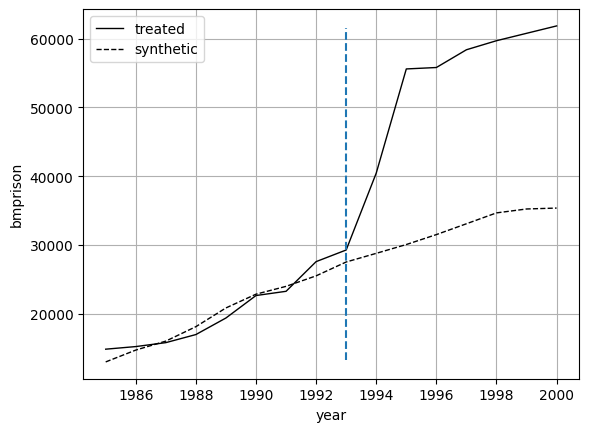

In [4]:
synth.path_plot(treatment_time=1993)

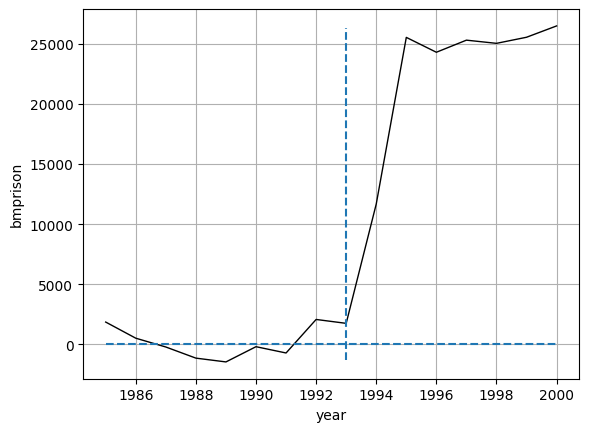

In [5]:
synth.gaps_plot(treatment_time=1993)

In [6]:
synth.summary()

,V,treated,synthetic,sample mean
bmprison,0.002,36091.188,25691.531,7056.444
income,0.000,19690.562,22273.230,20645.052
ur,0.000,6.525,6.622,5.526
poverty,0.000,16.912,14.738,12.985
special.1.bmprison,0.048,16956.000,18104.470,4872.160
special.2.bmprison,0.061,22634.000,22830.531,6098.230
special.3.bmprison,0.055,23249.000,23969.133,6560.480
special.4.bmprison,0.090,27568.000,25498.171,6971.660
special.5.alcohol,0.000,2.470,2.706,2.504
special.6.aidscapita,0.017,13.590,14.642,8.763
